# GANs For Art

## Importing the modules

In [5]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [59]:
artists = pd.read_csv("../input/best-artworks-of-all-time/artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [7]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="../input/best-artworks-of-all-time/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8683


torch.Size([3, 64, 64])


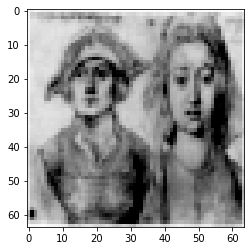

In [65]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

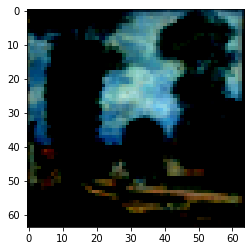

In [70]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

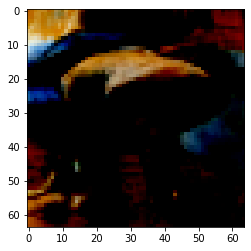

In [72]:
images,_ = train_ds[1912]
plt.imshow(images.permute(1,2,0))

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

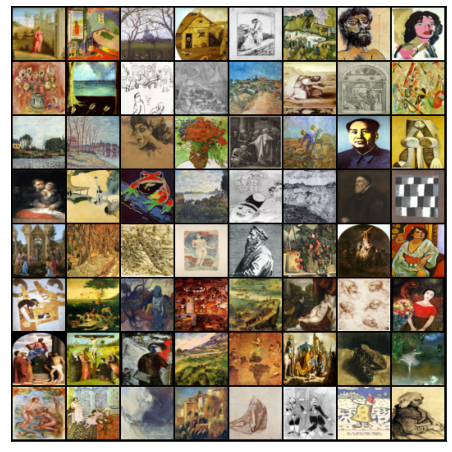

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [27]:
latent_size = 150

In [28]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


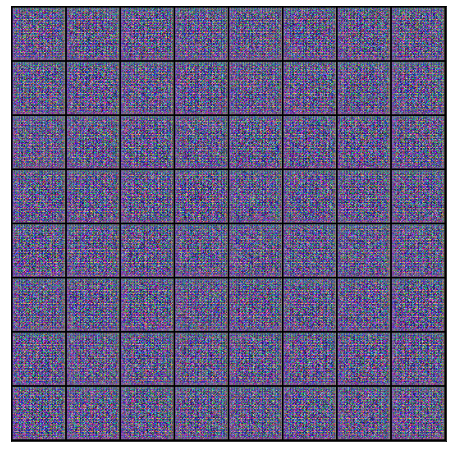

In [29]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [30]:
generator = to_device(generator, device)

In [31]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [32]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [33]:
from torchvision.utils import save_image

In [34]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


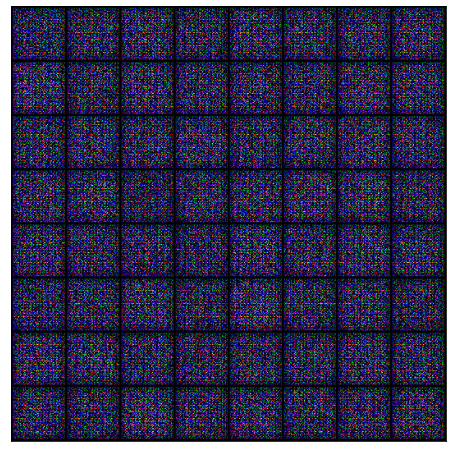

In [37]:
save_samples(0, fixed_latent)

In [38]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [39]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:
!pip install jovian --upgrade --quiet

In [48]:
import jovian

In [99]:
jovian.commit(project="project-GANs for Art", environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/blue-marker/project-GANs for Art


<IPython.core.display.Javascript object>

In [53]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [52]:
lr = 0.001
epochs = 150

In [47]:
history = fit(epochs,lr)


Epoch [1/150], loss_g: 0.3724, loss_d: 1.9993, real_score: 0.1933, fake_score: 0.0187
Saving generated-images-0001.png



Epoch [2/150], loss_g: 6.1118, loss_d: 2.1059, real_score: 0.9956, fake_score: 0.8204
Saving generated-images-0002.png



Epoch [3/150], loss_g: 2.5248, loss_d: 0.5635, real_score: 0.7304, fake_score: 0.1581
Saving generated-images-0003.png



Epoch [4/150], loss_g: 4.8193, loss_d: 0.6649, real_score: 0.8950, fake_score: 0.3854
Saving generated-images-0004.png



Epoch [5/150], loss_g: 1.0033, loss_d: 1.6307, real_score: 0.2852, fake_score: 0.1104
Saving generated-images-0005.png



Epoch [6/150], loss_g: 1.3924, loss_d: 1.2913, real_score: 0.4151, fake_score: 0.2515
Saving generated-images-0006.png



Epoch [7/150], loss_g: 3.7229, loss_d: 1.6265, real_score: 0.8758, fake_score: 0.7219
Saving generated-images-0007.png



Epoch [8/150], loss_g: 1.5024, loss_d: 0.8942, real_score: 0.5145, fake_score: 0.1307
Saving generated-images-0008.png



Epoch [9/150], loss_g: 2.7389, loss_d: 1.0016, real_score: 0.4491, fake_score: 0.0523
Saving generated-images-0009.png



Epoch [10/150], loss_g: 1.2592, loss_d: 0.9557, real_score: 0.5181, fake_score: 0.1936
Saving generated-images-0010.png



Epoch [11/150], loss_g: 5.4778, loss_d: 1.8307, real_score: 0.9768, fake_score: 0.7825
Saving generated-images-0011.png



Epoch [12/150], loss_g: 6.2485, loss_d: 1.3297, real_score: 0.9044, fake_score: 0.6403
Saving generated-images-0012.png



Epoch [13/150], loss_g: 3.3391, loss_d: 1.0478, real_score: 0.6466, fake_score: 0.2995
Saving generated-images-0013.png



Epoch [14/150], loss_g: 7.9008, loss_d: 2.1605, real_score: 0.9587, fake_score: 0.8425
Saving generated-images-0014.png



Epoch [15/150], loss_g: 7.8406, loss_d: 1.4966, real_score: 0.8287, fake_score: 0.6859
Saving generated-images-0015.png



Epoch [16/150], loss_g: 7.0731, loss_d: 2.1692, real_score: 0.7673, fake_score: 0.6677
Saving generated-images-0016.png



Epoch [17/150], loss_g: 5.2260, loss_d: 0.5972, real_score: 0.9083, fake_score: 0.3533
Saving generated-images-0017.png



Epoch [18/150], loss_g: 6.7091, loss_d: 1.7345, real_score: 0.8630, fake_score: 0.7240
Saving generated-images-0018.png



Epoch [19/150], loss_g: 2.9178, loss_d: 0.6093, real_score: 0.6657, fake_score: 0.0991
Saving generated-images-0019.png



Epoch [20/150], loss_g: 3.3261, loss_d: 0.9054, real_score: 0.4719, fake_score: 0.0243
Saving generated-images-0020.png



Epoch [21/150], loss_g: 2.8154, loss_d: 0.6746, real_score: 0.6199, fake_score: 0.0861
Saving generated-images-0021.png



Epoch [22/150], loss_g: 3.7875, loss_d: 0.6064, real_score: 0.8297, fake_score: 0.2644
Saving generated-images-0022.png



Epoch [23/150], loss_g: 3.5842, loss_d: 0.6960, real_score: 0.5933, fake_score: 0.0607
Saving generated-images-0023.png



Epoch [24/150], loss_g: 3.8048, loss_d: 0.6704, real_score: 0.8996, fake_score: 0.3752
Saving generated-images-0024.png



Epoch [25/150], loss_g: 2.7313, loss_d: 1.3294, real_score: 0.3603, fake_score: 0.0243
Saving generated-images-0025.png



Epoch [26/150], loss_g: 4.2227, loss_d: 0.4698, real_score: 0.7299, fake_score: 0.0799
Saving generated-images-0026.png



Epoch [27/150], loss_g: 4.8357, loss_d: 1.0219, real_score: 0.9216, fake_score: 0.5374
Saving generated-images-0027.png



Epoch [28/150], loss_g: 4.5780, loss_d: 0.7036, real_score: 0.7737, fake_score: 0.2885
Saving generated-images-0028.png



Epoch [29/150], loss_g: 2.5418, loss_d: 0.6205, real_score: 0.6689, fake_score: 0.1067
Saving generated-images-0029.png



Epoch [30/150], loss_g: 3.2268, loss_d: 0.5692, real_score: 0.6910, fake_score: 0.1135
Saving generated-images-0030.png



Epoch [31/150], loss_g: 3.1905, loss_d: 0.8606, real_score: 0.7114, fake_score: 0.3166
Saving generated-images-0031.png



Epoch [32/150], loss_g: 3.1752, loss_d: 0.7063, real_score: 0.6520, fake_score: 0.1325
Saving generated-images-0032.png



Epoch [33/150], loss_g: 1.6017, loss_d: 0.4692, real_score: 0.7745, fake_score: 0.1486
Saving generated-images-0033.png



Epoch [34/150], loss_g: 3.1367, loss_d: 0.5758, real_score: 0.7707, fake_score: 0.2186
Saving generated-images-0034.png



Epoch [35/150], loss_g: 2.2444, loss_d: 0.8270, real_score: 0.6238, fake_score: 0.2094
Saving generated-images-0035.png



Epoch [36/150], loss_g: 3.9700, loss_d: 0.8056, real_score: 0.7493, fake_score: 0.3431
Saving generated-images-0036.png



Epoch [37/150], loss_g: 3.2140, loss_d: 0.6055, real_score: 0.8071, fake_score: 0.2654
Saving generated-images-0037.png



Epoch [38/150], loss_g: 4.5331, loss_d: 0.5674, real_score: 0.8892, fake_score: 0.3023
Saving generated-images-0038.png



Epoch [39/150], loss_g: 2.3560, loss_d: 0.5352, real_score: 0.7496, fake_score: 0.1684
Saving generated-images-0039.png



Epoch [40/150], loss_g: 4.0386, loss_d: 0.6661, real_score: 0.7924, fake_score: 0.2979
Saving generated-images-0040.png



Epoch [41/150], loss_g: 2.4940, loss_d: 0.6126, real_score: 0.6771, fake_score: 0.1246
Saving generated-images-0041.png



Epoch [42/150], loss_g: 3.1215, loss_d: 0.6028, real_score: 0.9026, fake_score: 0.3366
Saving generated-images-0042.png



Epoch [43/150], loss_g: 3.2074, loss_d: 0.4528, real_score: 0.9013, fake_score: 0.2564
Saving generated-images-0043.png



Epoch [44/150], loss_g: 1.8966, loss_d: 1.0664, real_score: 0.5656, fake_score: 0.2331
Saving generated-images-0044.png



Epoch [45/150], loss_g: 5.6140, loss_d: 0.6679, real_score: 0.9223, fake_score: 0.3975
Saving generated-images-0045.png



Epoch [46/150], loss_g: 1.2586, loss_d: 2.6808, real_score: 0.1140, fake_score: 0.0078
Saving generated-images-0046.png



Epoch [47/150], loss_g: 4.7770, loss_d: 1.1916, real_score: 0.9715, fake_score: 0.6076
Saving generated-images-0047.png



Epoch [48/150], loss_g: 4.2931, loss_d: 0.4187, real_score: 0.8595, fake_score: 0.1879
Saving generated-images-0048.png



Epoch [49/150], loss_g: 2.5328, loss_d: 0.5160, real_score: 0.7254, fake_score: 0.0674
Saving generated-images-0049.png



Epoch [50/150], loss_g: 6.2171, loss_d: 1.0693, real_score: 0.9338, fake_score: 0.5382
Saving generated-images-0050.png



Epoch [51/150], loss_g: 3.2875, loss_d: 0.9603, real_score: 0.4570, fake_score: 0.0125
Saving generated-images-0051.png



Epoch [52/150], loss_g: 5.4075, loss_d: 0.4858, real_score: 0.9354, fake_score: 0.2862
Saving generated-images-0052.png



Epoch [53/150], loss_g: 7.0839, loss_d: 1.2986, real_score: 0.9922, fake_score: 0.6314
Saving generated-images-0053.png



Epoch [54/150], loss_g: 2.4387, loss_d: 0.4433, real_score: 0.7664, fake_score: 0.1224
Saving generated-images-0054.png



Epoch [55/150], loss_g: 7.0416, loss_d: 0.4518, real_score: 0.9541, fake_score: 0.2834
Saving generated-images-0055.png



Epoch [56/150], loss_g: 5.2649, loss_d: 0.4496, real_score: 0.9439, fake_score: 0.2834
Saving generated-images-0056.png



Epoch [57/150], loss_g: 4.0155, loss_d: 0.3992, real_score: 0.7451, fake_score: 0.0289
Saving generated-images-0057.png



Epoch [58/150], loss_g: 5.2767, loss_d: 0.3211, real_score: 0.8859, fake_score: 0.1430
Saving generated-images-0058.png



Epoch [59/150], loss_g: 4.6839, loss_d: 0.2501, real_score: 0.9515, fake_score: 0.1602
Saving generated-images-0059.png



Epoch [60/150], loss_g: 3.3519, loss_d: 0.6871, real_score: 0.6124, fake_score: 0.0203
Saving generated-images-0060.png



Epoch [61/150], loss_g: 4.1809, loss_d: 0.2904, real_score: 0.8429, fake_score: 0.0818
Saving generated-images-0061.png



Epoch [62/150], loss_g: 5.7535, loss_d: 0.2826, real_score: 0.7992, fake_score: 0.0265
Saving generated-images-0062.png



Epoch [63/150], loss_g: 2.6341, loss_d: 0.3277, real_score: 0.8269, fake_score: 0.0849
Saving generated-images-0063.png



Epoch [64/150], loss_g: 5.6567, loss_d: 0.2524, real_score: 0.9802, fake_score: 0.1760
Saving generated-images-0064.png



Epoch [65/150], loss_g: 10.2975, loss_d: 1.2531, real_score: 0.9930, fake_score: 0.6098
Saving generated-images-0065.png



Epoch [66/150], loss_g: 3.6767, loss_d: 0.4671, real_score: 0.7838, fake_score: 0.1184
Saving generated-images-0066.png



Epoch [67/150], loss_g: 6.3048, loss_d: 0.3750, real_score: 0.9803, fake_score: 0.2391
Saving generated-images-0067.png



Epoch [68/150], loss_g: 4.8326, loss_d: 0.2878, real_score: 0.8097, fake_score: 0.0237
Saving generated-images-0068.png



Epoch [69/150], loss_g: 3.5091, loss_d: 0.5552, real_score: 0.6746, fake_score: 0.0252
Saving generated-images-0069.png



Epoch [70/150], loss_g: 6.7993, loss_d: 1.0620, real_score: 0.9087, fake_score: 0.3154
Saving generated-images-0070.png



Epoch [71/150], loss_g: 5.9132, loss_d: 0.5781, real_score: 0.9631, fake_score: 0.3392
Saving generated-images-0071.png



Epoch [72/150], loss_g: 5.6638, loss_d: 0.1364, real_score: 0.9489, fake_score: 0.0727
Saving generated-images-0072.png



Epoch [73/150], loss_g: 4.6677, loss_d: 0.3220, real_score: 0.8846, fake_score: 0.1489
Saving generated-images-0073.png



Epoch [74/150], loss_g: 5.9179, loss_d: 0.2787, real_score: 0.9449, fake_score: 0.1210
Saving generated-images-0074.png



Epoch [75/150], loss_g: 3.7402, loss_d: 0.2500, real_score: 0.8901, fake_score: 0.0823
Saving generated-images-0075.png



Epoch [76/150], loss_g: 5.1714, loss_d: 0.2227, real_score: 0.9660, fake_score: 0.1423
Saving generated-images-0076.png



Epoch [77/150], loss_g: 3.8671, loss_d: 0.3211, real_score: 0.8595, fake_score: 0.0916
Saving generated-images-0077.png



Epoch [78/150], loss_g: 5.3121, loss_d: 0.3094, real_score: 0.9529, fake_score: 0.1919
Saving generated-images-0078.png



Epoch [79/150], loss_g: 2.4547, loss_d: 2.8359, real_score: 0.3434, fake_score: 0.0761
Saving generated-images-0079.png



Epoch [80/150], loss_g: 2.0455, loss_d: 0.4042, real_score: 0.7645, fake_score: 0.0584
Saving generated-images-0080.png



Epoch [81/150], loss_g: 4.2844, loss_d: 0.1586, real_score: 0.9050, fake_score: 0.0437
Saving generated-images-0081.png



Epoch [82/150], loss_g: 6.5057, loss_d: 0.5367, real_score: 0.9228, fake_score: 0.2542
Saving generated-images-0082.png



Epoch [83/150], loss_g: 4.5669, loss_d: 0.1485, real_score: 0.9126, fake_score: 0.0424
Saving generated-images-0083.png



Epoch [84/150], loss_g: 5.9658, loss_d: 0.1021, real_score: 0.9726, fake_score: 0.0521
Saving generated-images-0084.png



Epoch [85/150], loss_g: 5.4219, loss_d: 0.1834, real_score: 0.9404, fake_score: 0.0872
Saving generated-images-0085.png



Epoch [86/150], loss_g: 2.2980, loss_d: 0.2275, real_score: 0.8703, fake_score: 0.0266
Saving generated-images-0086.png



Epoch [87/150], loss_g: 6.0935, loss_d: 0.3667, real_score: 0.8989, fake_score: 0.1428
Saving generated-images-0087.png



Epoch [88/150], loss_g: 4.3103, loss_d: 0.2921, real_score: 0.8276, fake_score: 0.0469
Saving generated-images-0088.png



Epoch [89/150], loss_g: 6.3980, loss_d: 1.3656, real_score: 0.9796, fake_score: 0.5484
Saving generated-images-0089.png



Epoch [90/150], loss_g: 4.8826, loss_d: 0.2224, real_score: 0.9075, fake_score: 0.0980
Saving generated-images-0090.png



Epoch [91/150], loss_g: 5.6516, loss_d: 0.1148, real_score: 0.9703, fake_score: 0.0740
Saving generated-images-0091.png



Epoch [92/150], loss_g: 4.6358, loss_d: 0.3782, real_score: 0.7444, fake_score: 0.0136
Saving generated-images-0092.png



Epoch [93/150], loss_g: 5.7375, loss_d: 0.1274, real_score: 0.9295, fake_score: 0.0347
Saving generated-images-0093.png



Epoch [94/150], loss_g: 4.6041, loss_d: 0.1315, real_score: 0.9821, fake_score: 0.0955
Saving generated-images-0094.png



Epoch [95/150], loss_g: 1.2193, loss_d: 5.3158, real_score: 0.0424, fake_score: 0.0002
Saving generated-images-0095.png



Epoch [96/150], loss_g: 5.2756, loss_d: 0.1984, real_score: 0.9438, fake_score: 0.1109
Saving generated-images-0096.png



Epoch [97/150], loss_g: 4.7502, loss_d: 0.2682, real_score: 0.9269, fake_score: 0.1312
Saving generated-images-0097.png



Epoch [98/150], loss_g: 2.3470, loss_d: 1.1229, real_score: 0.5174, fake_score: 0.0131
Saving generated-images-0098.png



Epoch [99/150], loss_g: 3.8475, loss_d: 0.1714, real_score: 0.8923, fake_score: 0.0315
Saving generated-images-0099.png



Epoch [100/150], loss_g: 3.2681, loss_d: 0.3488, real_score: 0.8097, fake_score: 0.0795
Saving generated-images-0100.png



Epoch [101/150], loss_g: 3.5999, loss_d: 0.1073, real_score: 0.9499, fake_score: 0.0453
Saving generated-images-0101.png



Epoch [102/150], loss_g: 3.8018, loss_d: 0.1372, real_score: 0.8898, fake_score: 0.0082
Saving generated-images-0102.png



Epoch [103/150], loss_g: 4.9345, loss_d: 0.0374, real_score: 0.9768, fake_score: 0.0130
Saving generated-images-0103.png



Epoch [104/150], loss_g: 5.7918, loss_d: 0.1797, real_score: 0.9971, fake_score: 0.1310
Saving generated-images-0104.png



Epoch [105/150], loss_g: 4.3461, loss_d: 0.5299, real_score: 0.7416, fake_score: 0.0805
Saving generated-images-0105.png



Epoch [106/150], loss_g: 4.8942, loss_d: 0.1528, real_score: 0.9500, fake_score: 0.0784
Saving generated-images-0106.png



Epoch [107/150], loss_g: 5.0132, loss_d: 0.2180, real_score: 0.9193, fake_score: 0.0912
Saving generated-images-0107.png



Epoch [108/150], loss_g: 2.9328, loss_d: 0.3496, real_score: 0.7874, fake_score: 0.0419
Saving generated-images-0108.png



Epoch [109/150], loss_g: 5.8324, loss_d: 0.1166, real_score: 0.9843, fake_score: 0.0783
Saving generated-images-0109.png



Epoch [110/150], loss_g: 4.8648, loss_d: 0.2574, real_score: 0.9808, fake_score: 0.1007
Saving generated-images-0110.png



Epoch [111/150], loss_g: 4.9244, loss_d: 0.1050, real_score: 0.9530, fake_score: 0.0372
Saving generated-images-0111.png



Epoch [112/150], loss_g: 5.4017, loss_d: 0.0671, real_score: 0.9748, fake_score: 0.0224
Saving generated-images-0112.png



Epoch [113/150], loss_g: 6.6337, loss_d: 0.0405, real_score: 0.9780, fake_score: 0.0160
Saving generated-images-0113.png



Epoch [114/150], loss_g: 5.5159, loss_d: 0.1624, real_score: 0.9672, fake_score: 0.0922
Saving generated-images-0114.png



Epoch [115/150], loss_g: 6.4443, loss_d: 0.0578, real_score: 0.9918, fake_score: 0.0345
Saving generated-images-0115.png



Epoch [116/150], loss_g: 8.4970, loss_d: 0.1075, real_score: 0.9921, fake_score: 0.0843
Saving generated-images-0116.png



Epoch [117/150], loss_g: 4.1785, loss_d: 0.2341, real_score: 0.9427, fake_score: 0.1069
Saving generated-images-0117.png



Epoch [118/150], loss_g: 4.1346, loss_d: 0.4320, real_score: 0.7857, fake_score: 0.0543
Saving generated-images-0118.png



Epoch [119/150], loss_g: 6.4404, loss_d: 0.0965, real_score: 0.9852, fake_score: 0.0700
Saving generated-images-0119.png



Epoch [120/150], loss_g: 5.9164, loss_d: 0.0967, real_score: 0.9802, fake_score: 0.0610
Saving generated-images-0120.png



Epoch [121/150], loss_g: 7.5673, loss_d: 0.0382, real_score: 0.9774, fake_score: 0.0125
Saving generated-images-0121.png



Epoch [122/150], loss_g: 5.3480, loss_d: 0.1370, real_score: 0.9777, fake_score: 0.0893
Saving generated-images-0122.png



Epoch [123/150], loss_g: 2.8182, loss_d: 6.7357, real_score: 0.5649, fake_score: 0.2596
Saving generated-images-0123.png



Epoch [124/150], loss_g: 4.1137, loss_d: 0.3666, real_score: 0.7817, fake_score: 0.0374
Saving generated-images-0124.png



Epoch [125/150], loss_g: 5.3851, loss_d: 0.1864, real_score: 0.9296, fake_score: 0.0414
Saving generated-images-0125.png



Epoch [126/150], loss_g: 6.3471, loss_d: 0.4219, real_score: 0.9769, fake_score: 0.2609
Saving generated-images-0126.png



Epoch [127/150], loss_g: 5.8448, loss_d: 0.1074, real_score: 0.9293, fake_score: 0.0200
Saving generated-images-0127.png



Epoch [128/150], loss_g: 7.4804, loss_d: 0.1268, real_score: 0.9854, fake_score: 0.0899
Saving generated-images-0128.png



Epoch [129/150], loss_g: 6.4094, loss_d: 0.0908, real_score: 0.9362, fake_score: 0.0132
Saving generated-images-0129.png



Epoch [130/150], loss_g: 3.4252, loss_d: 0.2972, real_score: 0.8284, fake_score: 0.0381
Saving generated-images-0130.png



Epoch [131/150], loss_g: 5.7635, loss_d: 0.1856, real_score: 0.9814, fake_score: 0.1306
Saving generated-images-0131.png



Epoch [132/150], loss_g: 5.6744, loss_d: 0.0334, real_score: 0.9762, fake_score: 0.0082
Saving generated-images-0132.png



Epoch [133/150], loss_g: 4.9573, loss_d: 0.1117, real_score: 0.9417, fake_score: 0.0370
Saving generated-images-0133.png



Epoch [134/150], loss_g: 4.4337, loss_d: 0.0609, real_score: 0.9942, fake_score: 0.0508
Saving generated-images-0134.png



Epoch [135/150], loss_g: 5.7947, loss_d: 0.1275, real_score: 0.9850, fake_score: 0.0872
Saving generated-images-0135.png



Epoch [136/150], loss_g: 6.5385, loss_d: 0.1374, real_score: 0.9046, fake_score: 0.0157
Saving generated-images-0136.png



Epoch [137/150], loss_g: 6.1385, loss_d: 0.0825, real_score: 0.9512, fake_score: 0.0255
Saving generated-images-0137.png



Epoch [138/150], loss_g: 4.3708, loss_d: 0.1471, real_score: 0.9104, fake_score: 0.0247
Saving generated-images-0138.png



Epoch [139/150], loss_g: 6.7394, loss_d: 0.0138, real_score: 0.9971, fake_score: 0.0105
Saving generated-images-0139.png



Epoch [140/150], loss_g: 7.2239, loss_d: 0.0543, real_score: 0.9830, fake_score: 0.0319
Saving generated-images-0140.png



Epoch [141/150], loss_g: 6.9821, loss_d: 0.0545, real_score: 0.9902, fake_score: 0.0384
Saving generated-images-0141.png



Epoch [142/150], loss_g: 1.9348, loss_d: 0.6614, real_score: 0.7021, fake_score: 0.0245
Saving generated-images-0142.png



Epoch [143/150], loss_g: 9.8316, loss_d: 0.4413, real_score: 0.9822, fake_score: 0.2534
Saving generated-images-0143.png



Epoch [144/150], loss_g: 5.5015, loss_d: 0.0240, real_score: 0.9971, fake_score: 0.0194
Saving generated-images-0144.png



Epoch [145/150], loss_g: 5.8658, loss_d: 0.1507, real_score: 0.9840, fake_score: 0.1084
Saving generated-images-0145.png



Epoch [146/150], loss_g: 4.9157, loss_d: 0.2210, real_score: 0.8828, fake_score: 0.0508
Saving generated-images-0146.png



Epoch [147/150], loss_g: 7.0359, loss_d: 0.0457, real_score: 0.9874, fake_score: 0.0291
Saving generated-images-0147.png



Epoch [148/150], loss_g: 5.6716, loss_d: 0.0286, real_score: 0.9793, fake_score: 0.0067
Saving generated-images-0148.png



Epoch [149/150], loss_g: 6.8343, loss_d: 0.0849, real_score: 0.9300, fake_score: 0.0023
Saving generated-images-0149.png



Epoch [150/150], loss_g: 5.9230, loss_d: 0.1252, real_score: 0.9688, fake_score: 0.0716
Saving generated-images-0150.png


In [76]:
from IPython.display import Image 

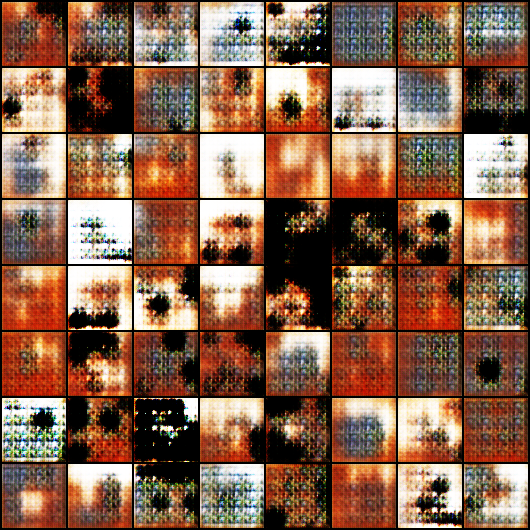

In [81]:
Image('./generated/generated-images-0013.png')

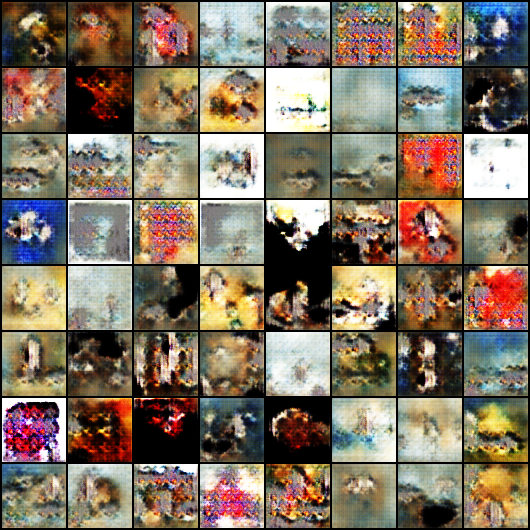

In [82]:
Image('./generated/generated-images-0037.png')

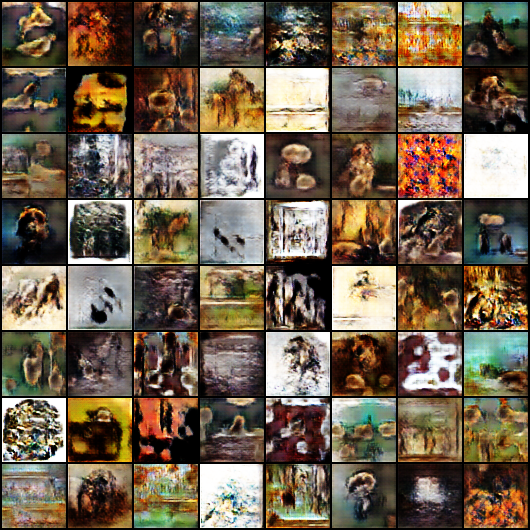

In [83]:
Image('./generated/generated-images-0072.png')

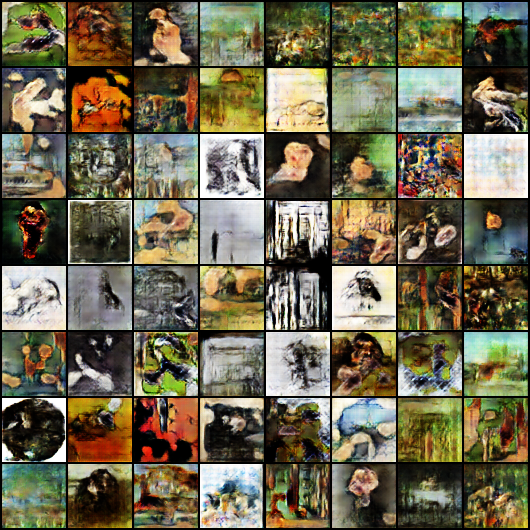

In [84]:
Image('./generated/generated-images-0103.png')

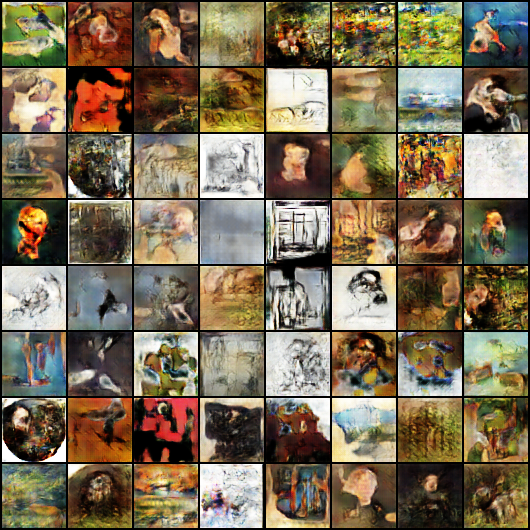

In [86]:
Image('./generated/generated-images-0138.png')

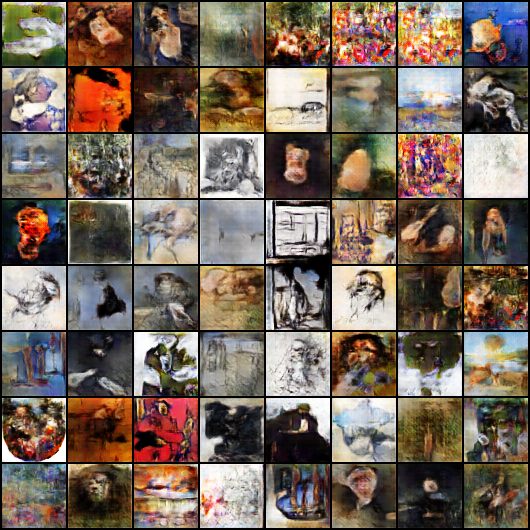

In [87]:
Image('./generated/generated-images-0147.png')

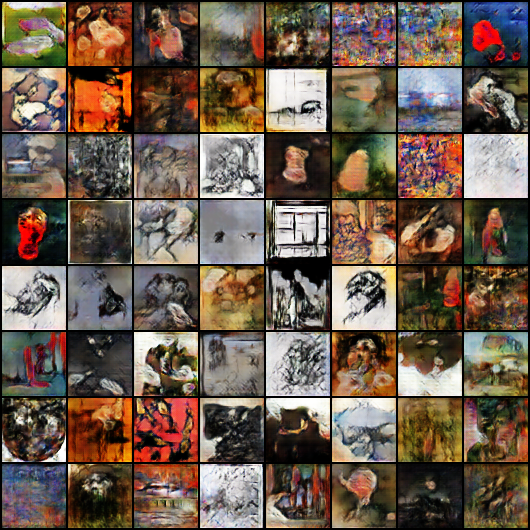

In [88]:
Image('./generated/generated-images-0150.png')

In [93]:
losses_g, losses_d, real_scores, fake_scores = history

In [94]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [95]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

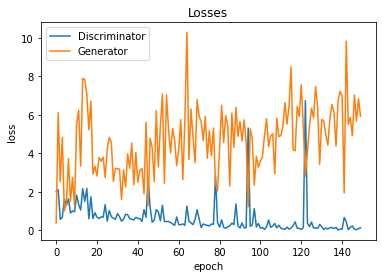

In [96]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

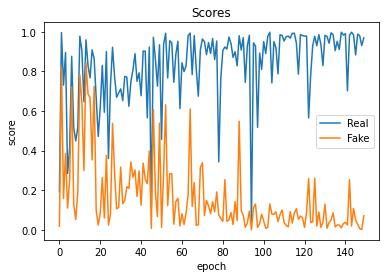

In [97]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [98]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()